# Telecom Churn Case Study

Following are carried out below:

1. Reading and basing understanding of data
2. Data cleaning
   a. Null Value calclation and dropping of cols with large no. of null values
   b. Null value imputation of columns with mostly or all 0s
   c. Use of Iterative Imputer for null-value imputation (KNN was used, but discarded later due to the large amount of time it took)
   d. Capping of Iterative imputed columns with max and min of that specific column, to ensure that **absurd** values generated during imputation, are eliminated
3. Data Filtering to get the top 30% high-value customers (HVC)
4. Generation of combined variables - all cloumns if month 6 and 7 are added up since they form good period
5. Some EDA to identify relationship between columns
6. Standard Scaling
7. PCA to reduce dimensionality
8. 3 models using PCA, along with their Metrics (from Confusion Matrix)
   a. Logistic Regression
   b. Random Forests
   c. Decision Trees
   d. **XGBoost was also tried but is not shown here**
9. An interpretable model, giving the most important variables

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import sklearn
import statsmodels.api as sm

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


from sklearn.feature_selection import RFE

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.metrics import r2_score

from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA

# Importing required packages for visualization
from IPython.display import Image  
from six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus, graphviz

from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

## 1.0 Reading and understanding data

In [2]:
telco = pd.read_csv('telecom_churn_data.csv')
telco.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [3]:
orig_shape = telco.shape
print(orig_shape)

(99999, 226)


In [4]:
print("Columns in the Original Dataset")
print("="*31)
telco.columns

Columns in the Original Dataset


Index(['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou',
       'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7',
       'last_date_of_month_8', 'last_date_of_month_9', 'arpu_6',
       ...
       'sachet_3g_9', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9',
       'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g'],
      dtype='object', length=226)

In [5]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [6]:
telco.describe()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
count,9.999900e+04,99999.0,98981.0,98981.0,98981.0,99999.000000,99999.000000,99999.000000,99999.000000,96062.000000,...,99999.000000,25153.000000,25571.000000,26339.000000,25922.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,7.001207e+09,109.0,0.0,0.0,0.0,282.987358,278.536648,279.154731,261.645069,132.395875,...,0.084581,0.914404,0.908764,0.890808,0.860968,1219.854749,68.170248,66.839062,60.021204,3.299373
std,6.956694e+05,0.0,0.0,0.0,0.0,328.439770,338.156291,344.474791,341.998630,297.207406,...,0.650457,0.279772,0.287950,0.311885,0.345987,954.733842,267.580450,271.201856,253.938223,32.408353
min,7.000000e+09,109.0,0.0,0.0,0.0,-2258.709000,-2014.045000,-945.808000,-1899.505000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000606e+09,109.0,0.0,0.0,0.0,93.411500,86.980500,84.126000,62.685000,7.380000,...,0.000000,1.000000,1.000000,1.000000,1.000000,467.000000,0.000000,0.000000,0.000000,0.000000
50%,7.001205e+09,109.0,0.0,0.0,0.0,197.704000,191.640000,192.080000,176.849000,34.310000,...,0.000000,1.000000,1.000000,1.000000,1.000000,863.000000,0.000000,0.000000,0.000000,0.000000
75%,7.001812e+09,109.0,0.0,0.0,0.0,371.060000,365.344500,369.370500,353.466500,118.740000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1807.500000,0.000000,0.000000,0.000000,0.000000
max,7.002411e+09,109.0,0.0,0.0,0.0,27731.088000,35145.834000,33543.624000,38805.617000,7376.710000,...,49.000000,1.000000,1.000000,1.000000,1.000000,4337.000000,12916.220000,9165.600000,11166.210000,2618.570000


In [7]:
telco.isnull().sum()

mobile_number        0
circle_id            0
loc_og_t2o_mou    1018
std_og_t2o_mou    1018
loc_ic_t2o_mou    1018
                  ... 
aon                  0
aug_vbc_3g           0
jul_vbc_3g           0
jun_vbc_3g           0
sep_vbc_3g           0
Length: 226, dtype: int64

### 1.1 Observations
- The dataset is huge, with 100,000 rows and 214 columns
- Most of the columns are numeric columns, with columns for the good months, the action month and churn month
- Quite a few columns have nulls

## 2.0 Data Cleaning

### 2.1 Handling Nulls

In [8]:
null_cols_pct = round((telco.isnull().sum()*100/orig_shape[0]), 2)
print(null_cols_pct[null_cols_pct > 20])
print(null_cols_pct[null_cols_pct > 20].index)
print(len(null_cols_pct[null_cols_pct > 0]))

date_of_last_rech_data_6    74.85
date_of_last_rech_data_7    74.43
date_of_last_rech_data_8    73.66
date_of_last_rech_data_9    74.08
total_rech_data_6           74.85
total_rech_data_7           74.43
total_rech_data_8           73.66
total_rech_data_9           74.08
max_rech_data_6             74.85
max_rech_data_7             74.43
max_rech_data_8             73.66
max_rech_data_9             74.08
count_rech_2g_6             74.85
count_rech_2g_7             74.43
count_rech_2g_8             73.66
count_rech_2g_9             74.08
count_rech_3g_6             74.85
count_rech_3g_7             74.43
count_rech_3g_8             73.66
count_rech_3g_9             74.08
av_rech_amt_data_6          74.85
av_rech_amt_data_7          74.43
av_rech_amt_data_8          73.66
av_rech_amt_data_9          74.08
arpu_3g_6                   74.85
arpu_3g_7                   74.43
arpu_3g_8                   73.66
arpu_3g_9                   74.08
arpu_2g_6                   74.85
arpu_2g_7     

#### 2.1.1 Observations
- Many columns have null values > 70%
- We will not get much useful data from any of these columns
- So we will drop them
- **Except these, all other columns have null values < 10%, which will be imputed**

In [9]:
print(telco.shape)
high_null_cols = null_cols_pct[null_cols_pct > 20].index
telco = telco.drop(null_cols_pct[null_cols_pct > 20].index, axis = 1)
shape_curr = telco.shape
print(f'Current Shape of Dataset = {shape_curr}')
print(high_null_cols, len(high_null_cols))
print(telco.shape)

(99999, 226)
Current Shape of Dataset = (99999, 186)
Index(['date_of_last_rech_data_6', 'date_of_last_rech_data_7',
       'date_of_last_rech_data_8', 'date_of_last_rech_data_9',
       'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8',
       'total_rech_data_9', 'max_rech_data_6', 'max_rech_data_7',
       'max_rech_data_8', 'max_rech_data_9', 'count_rech_2g_6',
       'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_2g_9',
       'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8',
       'count_rech_3g_9', 'av_rech_amt_data_6', 'av_rech_amt_data_7',
       'av_rech_amt_data_8', 'av_rech_amt_data_9', 'arpu_3g_6', 'arpu_3g_7',
       'arpu_3g_8', 'arpu_3g_9', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8',
       'arpu_2g_9', 'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8',
       'night_pck_user_9', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'fb_user_9'],
      dtype='object') 40
(99999, 186)


In [10]:
null_cols_pct = round((telco.isnull().sum()*100/orig_shape[0]), 2)
print(null_cols_pct[null_cols_pct > 0].index, len(null_cols_pct[null_cols_pct > 0].index))

Index(['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'last_date_of_month_7', 'last_date_of_month_8', 'last_date_of_month_9',
       'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'onnet_mou_9',
       ...
       'isd_ic_mou_8', 'isd_ic_mou_9', 'ic_others_6', 'ic_others_7',
       'ic_others_8', 'ic_others_9', 'date_of_last_rech_6',
       'date_of_last_rech_7', 'date_of_last_rech_8', 'date_of_last_rech_9'],
      dtype='object', length=126) 126


#### 2.1.2 Zero-sum columns

In [11]:
zero_sum_cols = []
for col in null_cols_pct[null_cols_pct > 0].index:
    if(telco[col].dtype == object):
        continue
    if(telco[col].sum(axis = 0) == 0):
        zero_sum_cols.append(col)
print(zero_sum_cols)

['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_og_t2c_mou_9', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8', 'std_ic_t2o_mou_9']


- The above columns all have zero-sum, i.e., all entries in these columns are 0
- We simply impute nulls in these with 0, since that maintains the characteristic of these columns
- Later, these columns are deleted since they show no variance and so, don't add new informatio in predicting churn

In [12]:
for col in zero_sum_cols:
    telco[col] = telco[col].fillna(0.0)

In [13]:
null_cols_pct = round((telco.isnull().sum()*100/orig_shape[0]), 2)
print(len(null_cols_pct[null_cols_pct > 0]))

115


- Only 1 date column was converted to datetime format
- However, then it was decided to drop all date columns, since they don't add usable information
- We anyway have data for different months (_6, _7, _8 and _9). These are really useful columns

In [14]:
telco['last_date_of_month_7'] = pd.to_datetime(telco['last_date_of_month_7'], format = '%m/%d/%Y')

In [15]:
from fancyimpute import IterativeImputer

In [16]:
fancy = IterativeImputer()

- One of the columns with NAs was plotted, just to get an idea of its statistics
- A large number of outliers are seen

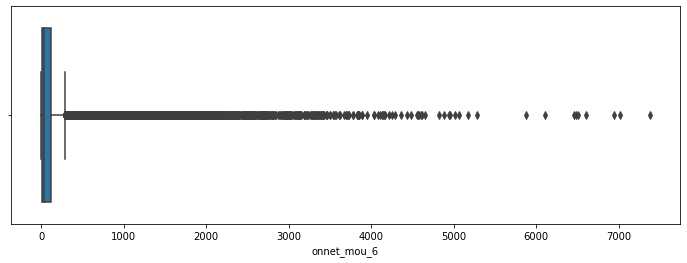

In [17]:
plt.figure(figsize = (12, 4))
sns.boxplot(telco['onnet_mou_6'], orient = 'h')
plt.show()

#### 2.1.3:
- Identify all `object` columns
- It can be seen that only date columns are object columns 
- These columns are just converted to date-time and then and these will be dropped

In [18]:
obj_cols = telco.loc[:, telco.dtypes == object].columns
print(obj_cols)
print()
float_cols = telco.loc[:, telco.dtypes == 'float64'].columns
null_cols = null_cols_pct[null_cols_pct > 0].index

nfcs = telco.dtypes[null_cols] == 'float64'
null_float_cols = nfcs[nfcs].index

print(f'len_obj_cols = {len(obj_cols)}, len_float_cols = {len(float_cols)}')
print(f'len_null_cols = {len(null_cols)}, len_null_float_cols = {len(null_float_cols)}')

Index(['last_date_of_month_6', 'last_date_of_month_8', 'last_date_of_month_9',
       'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8',
       'date_of_last_rech_9'],
      dtype='object')

len_obj_cols = 7, len_float_cols = 143
len_null_cols = 115, len_null_float_cols = 108


In [19]:
nocs = telco.dtypes[null_cols] != 'float64'
null_obj_cols = nocs[nocs].index
for obj_col in obj_cols:
    telco[obj_col] = pd.to_datetime(telco[obj_col], format = '%m/%d/%Y')
    
drop_date_cols = ['last_date_of_month_7', 'last_date_of_month_8', 'last_date_of_month_9', \
       'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8', \
       'date_of_last_rech_9']
telco = telco.drop(drop_date_cols, axis = 1)

- Just check the number of columns with nulls

In [20]:
null_cols_pct = round((telco.isnull().sum()*100/orig_shape[0]), 2)
print(len(null_cols_pct[null_cols_pct > 0]))

108


#### 2.1.4 Iterative Imputation
We now do iterative imputation of the nulls in the dataset.
Since the imputer takes a lot of time, the following is the process followed:

1. The dataset is divided into 2 sets of columns, one with nulls < 4%, another with nulls >= 4%
2. Imputations are done in 2 steps, once with the set < 4% and once with the set >= 4%
3. Since the Iterative Imputer can impute nulls with absurd values (> largest or < smallest values), the following is done to handle anamolies:
   - Before imputation, the nulls are filled with 0.
   - The largest and smallest values of every column are stored in a different dataset and this dataset is written into an XL file
   - Imputation is done
   - After imputation, the above dataset is read again and, if the imputed values are < the minimum values, they are clamped to the min value
   - If the imputed values are > the maximum values, they are clamped to the max value
4. This is done for both the imputations

In [21]:
print(len(null_cols_pct[null_cols_pct >= 4]))
null_cols = null_cols_pct[null_cols_pct > 0]
null_cols1 = null_cols[null_cols < 4].index
print(len(null_cols))
print(len(null_cols1))

54
108
54


In [22]:
min_val = []
max_val = []
for col in null_cols1:
    if(telco[col].dtype != 'float64'):
        continue
    telco[col] = telco[col].fillna(0.0)
    min_val.append(min(telco[col]))
    max_val.append(max(telco[col]))
    
max_min = pd.DataFrame({'minmum': min_val, 'maxmum': max_val})
max_min.to_csv('min_max_vals.csv', index = True)
print(len(min_val), len(max_val))
mm = pd.read_csv('min_max_vals.csv')
mm.head()

54 54


,Unnamed: 0,minmum,maxmum
0,0,0.0,7376.71
1,1,0.0,8157.78
2,2,0.0,8362.36
3,3,0.0,9667.13
4,4,0.0,13724.38


**2.1.4.1 Imputation 1:**

In [23]:
%%time
telco[null_cols1] = fancy.fit_transform(telco[null_cols1])
telco[null_cols1].head()

CPU times: user 42.2 s, sys: 2.78 s, total: 45 s
Wall time: 23.9 s


,onnet_mou_6,onnet_mou_7,offnet_mou_6,offnet_mou_7,roam_ic_mou_6,roam_ic_mou_7,roam_og_mou_6,roam_og_mou_7,loc_og_t2t_mou_6,loc_og_t2t_mou_7,...,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_mou_6,std_ic_mou_7,spl_ic_mou_6,spl_ic_mou_7,isd_ic_mou_6,isd_ic_mou_7,ic_others_6,ic_others_7
0,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00
1,24.11,78.68,15.74,99.84,0.0,0.00,0.0,0.00,23.88,74.56,...,0.00,0.00,5.90,0.00,0.00,0.0,1.83,0.00,0.00,0.00
2,11.54,55.24,143.33,220.59,0.0,0.00,0.0,0.00,7.19,28.74,...,21.73,58.34,139.33,306.66,0.21,0.0,0.00,0.85,0.93,3.14
3,99.91,54.39,123.31,109.01,0.0,54.86,0.0,28.09,73.68,34.81,...,1.18,0.00,45.99,105.01,0.59,0.0,0.00,0.00,0.00,0.00
4,50.31,149.44,76.96,91.88,0.0,0.00,0.0,0.00,50.31,149.44,...,0.00,0.00,1.93,0.25,0.00,0.0,0.00,0.00,0.48,0.00


In [24]:
mm = pd.read_csv('min_max_vals.csv')
mm.head()

for col in range(len(null_cols1)):
   if(telco.iloc[col][null_cols1[col]] < mm.iloc[col]['minmum']):
       print(mm[col]['minmum'], telco[col][null_cols1[col]])
       telco.iloc[col][null_cols1[col]] = 0.0 # mm.iloc[col]['minmum']
#    if(telco.iloc[col][null_cols1[col]] > mm.iloc[col]['maxmum']):
#        print(mm[col]['minmum'], telco[col][null_cols1[col]])
#        telco.iloc[col][null_cols1[col]] = mm.iloc[col]['maxmum']
print("Capping Done")

Capping Done


In [25]:
null_cols_pct = round((telco.isnull().sum()*100/orig_shape[0]), 2)
null_cols2 = null_cols_pct[null_cols_pct > 0]
null_cols3 = null_cols2[null_cols2 < 4].index
print(len(null_cols2))
print(len(null_cols3))

54
0


In [26]:
mscols4 = [col for col in null_cols3 if 'monthly' in col or 'sachet' in col]
print(mscols4)

[]


In [27]:
null_cols4 = null_cols[null_cols_pct > 4]
null_cols4_idx = null_cols4.index

In [28]:
min_val = []
max_val = []
for col in null_cols4_idx:
    if(telco[col].dtype != 'float64'):
        continue
    telco[col] = telco[col].fillna(0.0)
    min_val.append(min(telco[col]))
    max_val.append(max(telco[col]))
    
max_min = pd.DataFrame({'minmum': min_val, 'maxmum': max_val})
max_min.to_csv('min_max_vals4.csv', index = True)
print(len(min_val), len(max_val))
mm4 = pd.read_csv('min_max_vals4.csv')
mm4.head()

54 54


,Unnamed: 0,minmum,maxmum
0,0,0.0,10752.56
1,1,0.0,10427.46
2,2,0.0,14007.34
3,3,0.0,10310.76
4,4,0.0,13095.36


**2.1.4.2 Imputation 2:**

In [29]:
%%time
telco[null_cols4_idx] = fancy.fit_transform(telco[null_cols4_idx])
telco[null_cols4_idx].head()

CPU times: user 42.1 s, sys: 2.81 s, total: 44.9 s
Wall time: 23.5 s


,onnet_mou_8,onnet_mou_9,offnet_mou_8,offnet_mou_9,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_8,loc_og_t2t_mou_9,...,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_mou_8,std_ic_mou_9,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_8,isd_ic_mou_9,ic_others_8,ic_others_9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.00
1,7.68,18.34,304.76,53.76,0.00,0.00,0.00,0.00,7.68,18.34,...,0.00,0.00,14.84,15.01,0.0,0.00,0.0,0.00,0.0,0.00
2,37.26,74.81,208.36,118.91,0.00,38.49,0.00,70.94,13.58,14.39,...,43.23,3.86,239.03,171.49,0.0,0.45,0.0,0.01,0.0,0.36
3,310.98,241.71,71.68,113.54,44.38,0.00,39.04,0.00,10.61,15.49,...,0.00,0.00,4.94,143.83,0.0,0.55,0.0,0.00,0.0,0.80
4,83.89,58.78,124.26,45.81,0.00,0.00,0.00,0.00,83.89,58.78,...,0.00,0.00,0.86,2.31,0.0,0.18,0.0,0.00,0.0,0.00


In [30]:
mm = pd.read_csv('min_max_vals4.csv')
mm.head()

for col in range(len(null_cols4_idx)):
   if(telco.iloc[col][null_cols4_idx[col]] < mm.iloc[col]['minmum']):
       print(mm[col]['minmum'], telco[col][null_cols4_idx[col]])
       telco.iloc[col][null_cols4_idx[col]] = 0.0  # mm.iloc[col]['minmum']
#    if(telco.iloc[col][null_cols4_idx[col]] > mm.iloc[col]['maxmum']):
#        print(mm[col]['minmum'], telco[col][null_cols4_idx[col]])
#        telco.iloc[col][null_cols4_idx[col]] = mm.iloc[col]['maxmum']
print("Capping Done 2")

Capping Done 2


In [31]:
null_cols_pct = round((telco.isnull().sum()*100/orig_shape[0]), 2)
print(null_cols_pct)
print(null_cols_pct[null_cols_pct > 0])

mobile_number     0.0
circle_id         0.0
loc_og_t2o_mou    0.0
std_og_t2o_mou    0.0
loc_ic_t2o_mou    0.0
                 ... 
aon               0.0
aug_vbc_3g        0.0
jul_vbc_3g        0.0
jun_vbc_3g        0.0
sep_vbc_3g        0.0
Length: 179, dtype: float64
Series([], dtype: float64)


* We can see from the above, that the % of nulls in the dataset is 0

In [32]:
telco_imp = telco

In [33]:
# telco.to_csv('telco_imputed1.csv', index = False, header = True)
# telco_imp = pd.read_csv('telco_imputed.csv')
# #print(telco.shape)
# print(telco_imp.shape)
# telco_imp.head()

In [34]:
sum_nulls = telco_imp.isnull().sum()
print(sum_nulls.sum())

0


#### 2.1.5 Identifying and selecting only High Value Customers
* A telecom company would always want to ensure that its high value customers do not churn.
* So, we identify those 30% customers who contribute to 70% of the company's revenue
* We take the total recharge amount of the 6th and 7th month, which are the good months, take the 70th percentile, and consider only those customers who recharge more than this

In [35]:
telco_imp['tot_rech_amt_6_7'] = telco_imp.total_rech_amt_6 + telco_imp.total_rech_amt_7
telco_imp.tot_rech_amt_6_7.head()

0    614
1    458
2    483
3    540
4    546
Name: tot_rech_amt_6_7, dtype: int64

In [36]:
q95 = telco_imp.tot_rech_amt_6_7.quantile(0.95)
q70 = telco_imp.tot_rech_amt_6_7.quantile(0.70)
q05 = telco_imp.tot_rech_amt_6_7.quantile(0.05)
print(q95, q70, q05)

1875.0 737.0 60.0


In [37]:
telco_imp = telco_imp[telco_imp['tot_rech_amt_6_7'] > q70]
telco_imp.tot_rech_amt_6_7.head()

7     2370
8     1038
13     760
16     918
17     816
Name: tot_rech_amt_6_7, dtype: int64

In [38]:
telco_imp.shape

(29979, 180)

#### 2.1.6 Identifying `churn`ed  HVC customers
* Further, in the 9th month all the cumstomers who curn, would already have churned
* So, we find out those customers whose usage in the 9th month is 0 (outgoing calls, incoming calls and data usage) and these are considered to have churned

In [39]:
print(telco_imp.shape[0])
churned = pd.Series(np.zeros(telco_imp.shape[0], dtype = int), dtype = int)

for i in range(telco_imp.shape[0]):
    if ( (telco_imp.iloc[i]['total_og_mou_9'] == 0.0) and \
        (telco_imp.iloc[i]['total_ic_mou_9'] == 0.0) and \
        (telco_imp.iloc[i]['vol_3g_mb_9'] == 0.0) and \
        (telco_imp.iloc[i]['vol_2g_mb_9'] == 0.0) ):
        churned[i] = 1


telco_imp['churn'] = churned.values

print(f'Sum of churned Series: {churned.sum()}')
print(f"SUM OF churn 2: {telco_imp.churn.sum()}")

telco_imp.churn.head()

29979
Sum of churned Series: 2589
SUM OF churn 2: 2589


7     1
8     0
13    0
16    0
17    0
Name: churn, dtype: int64

In [40]:
imbalance_pct = round(telco_imp['churn'].sum()*100/telco_imp['churn'].shape[0], 2)
print(imbalance_pct)

8.64


#### 2.1.7 Imbalance
- As can be seen from the above, only `8.64%` of the 29.9K high-value customers have churned
- This is a highly imbalanced target variable
- We later use the **Weight of Class balancing technique** to balance this DF, while running the classification algorithms

#### 2.1.8 Drop all 9th month values
* Having found out `churn`ed customers, we drop all the 9th month columns

In [41]:
cols_9 = [col for col in telco_imp.columns if '_9' in col]
telco_imp = telco_imp.drop(cols_9, axis = 1)
telco_shape = telco_imp.shape
print(telco_shape)

(29979, 139)


* We drop all columns whose sum is 0 since they don't give any variability wrt the target variable, churn

In [42]:
telco_imp = telco_imp.drop('last_date_of_month_6', axis = 1)

## 3.0 EDA to find some relationships

* Since there are too many variables, we can't plot all of them together
* So, we plot some sets of variables and find relationships between them
* We start by plotting onnet_mou_6, loc_og_t2t_mou_6, loc_og_t2f_mou_6, onnet_mou_7, loc_og_t2t_mou_7, loc_og_t2f_mou_7

In [43]:
# pp_cols = ['onnet_mou_6', 'loc_og_t2t_mou_6', 'loc_og_t2f_mou_6', 'onnet_mou_7', \
#            'loc_og_t2t_mou_7', 'loc_og_t2f_mou_7', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7', \
#           'std_og_t2f_mou_6', 'std_og_t2f_mou_7']

# telco_imp[pp_cols].head()
# sns.pairplot(telco_imp[pp_cols])
# plt.show()

In [44]:
# pp_cols = ['offnet_mou_6', 'loc_og_t2m_mou_6', 'offnet_mou_7', 'loc_og_t2m_mou_7']

# telco_imp[pp_cols].head()
# sns.pairplot(telco_imp[pp_cols])
# plt.show()

In [45]:
# pp_cols = ['std_ic_mou_6', 'std_ic_mou_7', 'isd_ic_mou_6', 'isd_ic_mou_7', 'std_og_mou_6', 'std_og_mou_7', 'isd_og_mou_6', 'isd_og_mou_7']
# sns.pairplot(telco_imp[pp_cols])
# plt.show()

* From the above plots, we can observe the following:
    - `offnet_mout_6` (and `offnet_mou_7`) and `loc_og_t2m_mou6` (and `loc_og_t2m_mou_6`) are very closely related to each other
    - `std_og_mou_6` and `std_og_mou_7` are also linearly related. 
    - Similarls `isd_og_mou_7` and `isd_og_mou_6` are also linearly related
    - The above 2 are just examples of observations
    - However, we add all the 6 and 7 columns since they form the good period

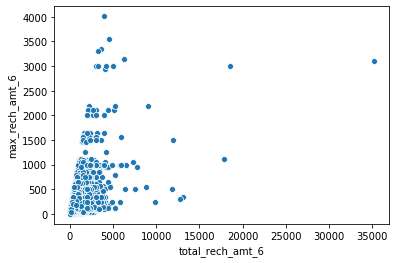

In [46]:
sns.scatterplot(telco['total_rech_amt_6'], telco['max_rech_amt_6'])
plt.show()

* From the above plot, we see that there is some linear relationship between `total_rech_amt_6` and `max_rech_amt_6`
* It is fairly logcal that the maximum recharge should have a bearing on the total recharge for a particular month

In [47]:
monthly_sachet_cols = [col for col in telco_imp.columns if 'monthly' in col or 'sachet' in col]
print(monthly_sachet_cols)

['monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8', 'sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8', 'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6', 'sachet_3g_7', 'sachet_3g_8']


In [48]:
telco_imp = telco_imp.drop(monthly_sachet_cols, axis = 1)

In [49]:
zero_sum_cols = [col for col in zero_sum_cols if '_9' not in col]
print(len(zero_sum_cols))
telco_imp = telco_imp.drop(zero_sum_cols, axis = 1)
telco_shape = telco_imp.shape
print(telco_shape)

9
(29979, 117)


## 4.0 Derived Variables
- 6 and 7 are part of good phase. So, for each variable, we can add 6th and 7th month columns to make 1 column and then drop all the separate 6 and 7 columns. This way
   - We will be reducing the number of columns
   - We will be reducing multicollinearity
   - Combining columns of the good phase and using them together

In [50]:
onnet_og_good_cols = [col for col in telco_imp.columns if ('loc_og_t2t' in col) and ('_6' in col or '_7' in col) ]
print(f'onnet_og_good_cols: {onnet_og_good_cols}')
telco_imp['og_onnet_good'] = telco_imp[onnet_og_good_cols].sum(axis = 1)
telco_imp['og_onnet_good'].head()
telco_imp = telco_imp.drop(onnet_og_good_cols, axis = 1)
print()

onnet_og_good_cols_t2f = [col for col in telco_imp.columns if ('loc_og_t2f' in col) and ('_6' in col or '_7' in col) ]
print(f'onnet_og_good_cols_t2f: {onnet_og_good_cols_t2f}')
telco_imp['og_onnet_good_t2f'] = telco_imp[onnet_og_good_cols_t2f].sum(axis = 1)
telco_imp['og_onnet_good_t2f'].head()
telco_imp = telco_imp.drop(onnet_og_good_cols_t2f, axis = 1)
print()

onnet_og_good_cols_std = [col for col in telco_imp.columns if ('std_og_t2t' in col) and ('_6' in col or '_7' in col) ]
print(f'onnet_og_good_cols_std: {onnet_og_good_cols_std}')
telco_imp['og_onnet_good_std'] = telco_imp[onnet_og_good_cols_std].sum(axis = 1)
telco_imp['og_onnet_good_std'].head()
telco_imp = telco_imp.drop(onnet_og_good_cols_std, axis = 1)
print()

onnet_og_good_cols_t2f_std = [col for col in telco_imp.columns if ('std_og_t2f' in col) and ('_6' in col or '_7' in col) ]
print(f'onnet_og_good_cols_t2f_std: {onnet_og_good_cols_t2f_std}')
telco_imp['og_onnet_good_t2f_std'] = telco_imp[onnet_og_good_cols_t2f_std].sum(axis = 1)
telco_imp['og_onnet_good_t2f_std'].head()
telco_imp = telco_imp.drop(onnet_og_good_cols_t2f_std, axis = 1)
print()

onnet_ic_good_cols = [col for col in telco_imp.columns if ('loc_ic_t2t' in col) and ('_6' in col or '_7' in col) ]
print(f'onnet_ic_good_cols: {onnet_ic_good_cols}')
telco_imp['ic_onnet_good'] = telco_imp[onnet_ic_good_cols].sum(axis = 1)
telco_imp['ic_onnet_good'].head()
telco_imp = telco_imp.drop(onnet_ic_good_cols, axis = 1)
print()

onnet_ic_good_cols_t2f = [col for col in telco_imp.columns if ('loc_ic_t2f' in col) and ('_6' in col or '_7' in col) ]
print(f'onnet_ic_good_cols_t2f: {onnet_ic_good_cols_t2f}')
telco_imp['ic_onnet_good_t2f'] = telco_imp[onnet_ic_good_cols_t2f].sum(axis = 1)
telco_imp['ic_onnet_good_t2f'].head()
telco_imp = telco_imp.drop(onnet_ic_good_cols_t2f, axis = 1)
print()

onnet_ic_good_cols_std = [col for col in telco_imp.columns if ('std_ic_t2t' in col) and ('_6' in col or '_7' in col) ]
print(f'onnet_ic_good_cols_std: {onnet_ic_good_cols_std}')
telco_imp['ic_onnet_good_std'] = telco_imp[onnet_ic_good_cols_std].sum(axis = 1)
telco_imp['ic_onnet_good_std'].head()
telco_imp = telco_imp.drop(onnet_ic_good_cols_std, axis = 1)
print()

onnet_ic_good_cols_t2f_std = [col for col in telco_imp.columns if ('std_ic_t2f' in col) and ('_6' in col or '_7' in col) ]
print(f'onnet_ic_good_cols_t2f_std: {onnet_ic_good_cols_t2f_std}')
telco_imp['ic_onnet_good_t2f_std'] = telco_imp[onnet_ic_good_cols_t2f_std].sum(axis = 1)
telco_imp['ic_onnet_good_t2f_std'].head()
telco_imp = telco_imp.drop(onnet_ic_good_cols_t2f_std, axis = 1)
print()

offnet_og_good_cols = [col for col in telco_imp.columns if ('loc_og_t2m' in col) and ('_6' in col or '_7' in col) ]
print(f'offnet_og_good_cols: {offnet_og_good_cols}')
telco_imp['og_offnet_good'] = telco_imp[offnet_og_good_cols].sum(axis = 1)
telco_imp['og_offnet_good'].head()
telco_imp = telco_imp.drop(offnet_og_good_cols, axis = 1)
print()

offnet_og_good_cols_std = [col for col in telco_imp.columns if ('std_og_t2m' in col) and ('_6' in col or '_7' in col) ]
print(f'offnet_og_good_cols_std: {offnet_og_good_cols_std}')
telco_imp['og_offnet_good_std'] = telco_imp[offnet_og_good_cols_std].sum(axis = 1)
telco_imp['og_offnet_good_std'].head()
telco_imp = telco_imp.drop(offnet_og_good_cols_std, axis = 1)
print()

offnet_ic_good_cols = [col for col in telco_imp.columns if ('loc_ic_t2m' in col) and ('_6' in col or '_7' in col) ]
print(f'offnet_ic_good_cols: {offnet_ic_good_cols}')
telco_imp['ic_offnet_good'] = telco_imp[offnet_ic_good_cols].sum(axis = 1)
telco_imp['ic_offnet_good'].head()
telco_imp = telco_imp.drop(offnet_ic_good_cols, axis = 1)

offnet_ic_good_cols_std = [col for col in telco_imp.columns if ('std_ic_t2m' in col) and ('_6' in col or '_7' in col) ]
print(f'offnet_ic_good_cols_std: {offnet_ic_good_cols_std}')
telco_imp['ic_offnet_good_std'] = telco_imp[offnet_ic_good_cols_std].sum(axis = 1)
telco_imp['ic_offnet_good_std'].head()
telco_imp = telco_imp.drop(offnet_ic_good_cols_std, axis = 1)

telco_imp.shape

onnet_og_good_cols: ['loc_og_t2t_mou_6', 'loc_og_t2t_mou_7']

onnet_og_good_cols_t2f: ['loc_og_t2f_mou_6', 'loc_og_t2f_mou_7']

onnet_og_good_cols_std: ['std_og_t2t_mou_6', 'std_og_t2t_mou_7']

onnet_og_good_cols_t2f_std: ['std_og_t2f_mou_6', 'std_og_t2f_mou_7']

onnet_ic_good_cols: ['loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7']

onnet_ic_good_cols_t2f: ['loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7']

onnet_ic_good_cols_std: ['std_ic_t2t_mou_6', 'std_ic_t2t_mou_7']

onnet_ic_good_cols_t2f_std: ['std_ic_t2f_mou_6', 'std_ic_t2f_mou_7']

offnet_og_good_cols: ['loc_og_t2m_mou_6', 'loc_og_t2m_mou_7']

offnet_og_good_cols_std: ['std_og_t2m_mou_6', 'std_og_t2m_mou_7']

offnet_ic_good_cols: ['loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7']
offnet_ic_good_cols_std: ['std_ic_t2m_mou_6', 'std_ic_t2m_mou_7']


(29979, 105)

In [51]:
vol_2g_mb_good = [col for col in telco_imp.columns if ('vol_2g_mb' in col) and ('_6' in col or '_7' in col) ]
print(f'vol_2g_mb_good: {vol_2g_mb_good}')
telco_imp['vol_2g_good'] = telco_imp[vol_2g_mb_good].sum(axis = 1)
telco_imp['vol_2g_good'].head()
telco_imp = telco_imp.drop(vol_2g_mb_good, axis = 1)
print()

vol_3g_mb_good = [col for col in telco_imp.columns if ('vol_3g_mb' in col) and ('_6' in col or '_7' in col) ]
print(f'vol_3g_mb_good: {vol_3g_mb_good}')
telco_imp['vol_3g_good'] = telco_imp[vol_3g_mb_good].sum(axis = 1)
telco_imp['vol_3g_good'].head()
telco_imp = telco_imp.drop(vol_3g_mb_good, axis = 1)
print()

rech_good_num = [col for col in telco_imp.columns if ('total_rech_num' in col) and ('_6' in col or '_7' in col) ]
print(f'rech_good_num: {rech_good_num}')
telco_imp['total_rech_num_good'] = telco_imp[rech_good_num].sum(axis = 1)
telco_imp['total_rech_num_good'].head()
telco_imp = telco_imp.drop(rech_good_num, axis = 1)
print()

rech_good_amt = [col for col in telco_imp.columns if ('total_rech_amt' in col) and ('_6' in col or '_7' in col) ]
print(f'rech_good_amt: {rech_good_amt}')
telco_imp['total_rech_amt_good'] = telco_imp[rech_good_amt].sum(axis = 1)
telco_imp['total_rech_amt_good'].head()
telco_imp = telco_imp.drop(rech_good_amt, axis = 1)
print()

max_rech_good = [col for col in telco_imp.columns if ('max_rech_amt' in col) and ('_6' in col or '_7' in col) ]
print(f'max_rech_good: {max_rech_good}')
telco_imp['max_rech_amt_good'] = telco_imp[max_rech_good].sum(axis = 1)
telco_imp['max_rech_amt_good'].head()
telco_imp = telco_imp.drop(max_rech_good, axis = 1)
print()

last_day_rech_amt_good = [col for col in telco_imp.columns if ('last_day_rch_amt' in col) and ('_6' in col or '_7' in col) ]
print(f'last_day_rech_amt_good: {last_day_rech_amt_good}')
telco_imp['last_day_rch_good'] = telco_imp[last_day_rech_amt_good].sum(axis = 1)
telco_imp['last_day_rch_good'].head()
telco_imp = telco_imp.drop(last_day_rech_amt_good, axis = 1)
print()

telco_imp.shape

vol_2g_mb_good: ['vol_2g_mb_6', 'vol_2g_mb_7']

vol_3g_mb_good: ['vol_3g_mb_6', 'vol_3g_mb_7']

rech_good_num: ['total_rech_num_6', 'total_rech_num_7']

rech_good_amt: ['total_rech_amt_6', 'total_rech_amt_7']

max_rech_good: ['max_rech_amt_6', 'max_rech_amt_7']

last_day_rech_amt_good: ['last_day_rch_amt_6', 'last_day_rch_amt_7']



(29979, 99)

In [52]:
telco_imp['arpu_good'] = telco_imp[['arpu_6', 'arpu_7']].sum(axis = 1)
telco_imp = telco_imp.drop(['arpu_6', 'arpu_7'], axis = 1)

telco_imp['onnet_good'] = telco_imp[['onnet_mou_6', 'onnet_mou_7']].sum(axis = 1)
telco_imp = telco_imp.drop(['onnet_mou_6', 'onnet_mou_7'], axis = 1)

telco_imp['offnet_good'] = telco_imp[['offnet_mou_6', 'offnet_mou_7']].sum(axis = 1)
telco_imp = telco_imp.drop(['offnet_mou_6', 'offnet_mou_7'], axis = 1)
telco_imp.shape

(29979, 96)

In [53]:
telco_imp['roam_ic_good'] = telco_imp[['roam_ic_mou_6', 'roam_ic_mou_7']].sum(axis = 1)
telco_imp = telco_imp.drop(['roam_ic_mou_6', 'roam_ic_mou_7'], axis = 1)

telco_imp['roam_og_good'] = telco_imp[['roam_og_mou_6', 'roam_og_mou_7']].sum(axis = 1)
telco_imp = telco_imp.drop(['roam_og_mou_6', 'roam_og_mou_7'], axis = 1)
telco_imp.shape

(29979, 94)

In [54]:
telco_imp['std_ic_good'] = telco_imp[['std_ic_mou_6', 'std_ic_mou_7']].sum(axis = 1)
telco_imp = telco_imp.drop(['std_ic_mou_6', 'std_ic_mou_7'], axis = 1)

telco_imp['std_og_good'] = telco_imp[['std_og_mou_6', 'std_og_mou_7']].sum(axis = 1)
telco_imp = telco_imp.drop(['std_og_mou_6', 'std_og_mou_7'], axis = 1)

telco_imp['isd_ic_good'] = telco_imp[['isd_ic_mou_6', 'isd_ic_mou_7']].sum(axis = 1)
telco_imp = telco_imp.drop(['isd_ic_mou_6', 'isd_ic_mou_7'], axis = 1)

telco_imp['isd_og_good'] = telco_imp[['isd_og_mou_6', 'isd_og_mou_7']].sum(axis = 1)
telco_imp = telco_imp.drop(['isd_og_mou_6', 'isd_og_mou_7'], axis = 1)
telco_imp.shape

(29979, 90)

In [55]:
telco_imp['loc_og_t2c_good'] = telco_imp[['loc_og_t2c_mou_6', 'loc_og_t2c_mou_7']].sum(axis = 1)
telco_imp = telco_imp.drop(['loc_og_t2c_mou_6', 'loc_og_t2c_mou_7'], axis = 1)

telco_imp['total_og_good'] = telco_imp[['total_og_mou_6', 'total_og_mou_7']].sum(axis = 1)
telco_imp = telco_imp.drop(['total_og_mou_6', 'total_og_mou_7'], axis = 1)
telco_imp.shape

(29979, 88)

In [56]:
telco_imp['loc_og_mou_good'] = telco_imp[['loc_og_mou_6', 'loc_og_mou_7']].sum(axis = 1)
telco_imp = telco_imp.drop(['loc_og_mou_6', 'loc_og_mou_7'], axis = 1)

telco_imp['spl_og_mou_good'] = telco_imp[['spl_og_mou_6', 'spl_og_mou_7']].sum(axis = 1)
telco_imp = telco_imp.drop(['spl_og_mou_6', 'spl_og_mou_7'], axis = 1)

telco_imp['og_others_good'] = telco_imp[['og_others_6', 'og_others_7']].sum(axis = 1)
telco_imp = telco_imp.drop(['og_others_6', 'og_others_7'], axis = 1)

telco_imp['loc_ic_mou_good'] = telco_imp[['loc_ic_mou_6', 'loc_ic_mou_7']].sum(axis = 1)
telco_imp = telco_imp.drop(['loc_ic_mou_6', 'loc_ic_mou_7'], axis = 1)

telco_imp['spl_ic_mou_good'] = telco_imp[['spl_ic_mou_6', 'spl_ic_mou_7']].sum(axis = 1)
telco_imp = telco_imp.drop(['spl_ic_mou_6', 'spl_ic_mou_7'], axis = 1)

telco_imp['ic_others_good'] = telco_imp[['ic_others_6', 'ic_others_7']].sum(axis = 1)
telco_imp = telco_imp.drop(['ic_others_6', 'ic_others_7'], axis = 1)

In [57]:
telco_imp['total_ic_mou_good'] = telco_imp[['total_ic_mou_6', 'total_ic_mou_7']].sum(axis = 1)
telco_imp = telco_imp.drop(['total_ic_mou_6', 'total_ic_mou_7'], axis = 1)
telco_imp.shape

(29979, 81)

In [58]:
telco_imp = telco_imp.drop('tot_rech_amt_6_7', axis = 1)

In [59]:
telco_imp = telco_imp.drop(['arpu_good', 'arpu_8'], axis = 1)

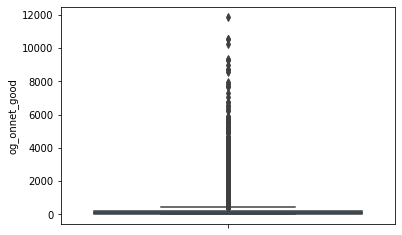

In [60]:
sns.boxplot(telco_imp['og_onnet_good'], orient = 'v')
plt.show()

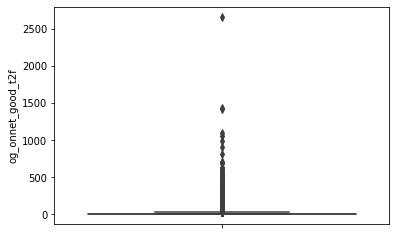

In [61]:
sns.boxplot(telco_imp['og_onnet_good_t2f'], orient = 'v')
plt.show()

* We can see from the above, that the og_onnet_good and og_onneg_good_t2f there are quite a few outliers in these 2 columns
* Similarly, the other numeric columns can also be expected to have outliers
* It would be required to Scale the numeric columns

**IMPORTANT OBSERVATION:**<br>
  One of the importatnt observation was:

- When we ran PCA **without scaling**, we found that the number of variables required for a particular variance_explained value, is **far lesser** than after scaling
    - Eg. With scaling, the no. of PCA components/variables required is 59
    - If we run this ame thing without scaling, the no. of variabls is about 30-35
- It is an observation that this might be due to the large number of outliers in the columns as seen above

In [62]:
X = telco_imp.drop('churn', axis = 1)
y = telco_imp['churn']

In [63]:
X = X.drop(['mobile_number', 'circle_id'], axis = 1)

In [64]:
num_cols = [col for col in X.columns if 'monthly' not in col and 'sachet' not in col]
len(num_cols)

75

In [65]:
telco_imp[num_cols].head()

,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2t_mou_8,...,isd_og_good,loc_og_t2c_good,total_og_good,loc_og_mou_good,spl_og_mou_good,og_others_good,loc_ic_mou_good,spl_ic_mou_good,ic_others_good,total_ic_mou_good
7,52.29,325.91,31.64,38.06,40.28,162.28,53.23,0.00,255.79,12.01,...,0.18,0.0,1096.77,956.07,4.50,0.00,783.11,0.21,30.93,1184.50
8,35.08,136.48,0.00,0.00,12.49,50.54,0.00,7.15,63.04,22.58,...,0.00,0.0,940.02,666.27,0.00,0.00,105.26,0.00,0.00,132.35
13,534.24,482.46,72.11,1.44,36.01,294.46,23.51,0.49,353.99,498.23,...,0.00,0.0,1099.50,258.79,0.00,0.00,241.69,0.45,99.72,1141.19
16,70.61,162.76,0.00,0.00,67.38,128.28,10.26,0.00,205.93,3.23,...,0.00,0.0,632.82,531.55,3.26,0.00,506.69,0.00,0.00,746.42
17,7.79,5.54,4.81,13.34,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.0,1250.34,97.54,2.58,0.93,84.27,0.00,0.00,94.19


## 5.0 High Performance models

### 5.1. PCA
* This database is a very big database with a huge number of columns
* Using all these columns and handling them will be a big problem.
* So, we do PCA to reduce the dimensionality of the dataset
* We then run the following models on the reduced dimension dataset:
   1. **Logistic Regression**
   2. **Random Forests**
   3. **Decision Tree**

In [66]:
pca = PCA(random_state = 42)

In [67]:
telco_imp.columns

Index(['mobile_number', 'circle_id', 'onnet_mou_8', 'offnet_mou_8',
       'roam_ic_mou_8', 'roam_og_mou_8', 'loc_og_t2t_mou_8',
       'loc_og_t2m_mou_8', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_8',
       'loc_og_mou_8', 'std_og_t2t_mou_8', 'std_og_t2m_mou_8',
       'std_og_t2f_mou_8', 'std_og_mou_8', 'isd_og_mou_8', 'spl_og_mou_8',
       'og_others_8', 'total_og_mou_8', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8',
       'loc_ic_t2f_mou_8', 'loc_ic_mou_8', 'std_ic_t2t_mou_8',
       'std_ic_t2m_mou_8', 'std_ic_t2f_mou_8', 'std_ic_mou_8',
       'total_ic_mou_8', 'spl_ic_mou_8', 'isd_ic_mou_8', 'ic_others_8',
       'total_rech_num_8', 'total_rech_amt_8', 'max_rech_amt_8',
       'last_day_rch_amt_8', 'vol_2g_mb_8', 'vol_3g_mb_8', 'aon', 'aug_vbc_3g',
       'jul_vbc_3g', 'jun_vbc_3g', 'sep_vbc_3g', 'churn', 'og_onnet_good',
       'og_onnet_good_t2f', 'og_onnet_good_std', 'og_onnet_good_t2f_std',
       'ic_onnet_good', 'ic_onnet_good_t2f', 'ic_onnet_good_std',
       'ic_onnet_good_t2f_st

#### 5.1.1  Train Test Split and Scaling
* We divide the data into train and test using a 70-30 ratio
* We then scale the train and test sets using the Standard scaler

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, test_size = 0.3, random_state = 42, stratify = y)
X_train.head()

,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2t_mou_8,...,isd_og_good,loc_og_t2c_good,total_og_good,loc_og_mou_good,spl_og_mou_good,og_others_good,loc_ic_mou_good,spl_ic_mou_good,ic_others_good,total_ic_mou_good
39311,328.64,214.84,135.66,279.34,4.91,60.66,0.00,0.00,65.58,186.71,...,0.00,6.88,3696.43,213.80,40.39,0.00,154.01,0.0,0.00,244.55
51422,44.98,454.71,55.41,204.13,10.53,43.14,3.36,0.00,57.04,5.41,...,0.00,4.03,602.32,111.34,17.10,0.00,95.76,0.0,0.00,231.94
43065,10.11,77.88,0.00,0.00,9.58,71.06,6.81,0.00,87.46,0.53,...,0.00,0.00,181.86,160.46,12.15,0.91,271.71,0.0,1.62,306.61
34894,195.64,300.14,0.00,0.00,100.89,150.49,110.73,0.00,362.13,94.74,...,0.13,0.00,868.42,644.94,9.52,0.00,260.00,0.0,0.05,322.44
89518,45.61,939.99,1.94,23.24,4.15,17.44,0.00,0.81,21.59,41.46,...,0.00,0.25,1455.44,65.02,0.91,0.00,53.76,0.0,0.99,57.67


In [70]:
scaler = StandardScaler()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_train.head()

X_test[num_cols] = scaler.transform(X_test[num_cols])
X_test.head()

,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2t_mou_8,...,isd_og_good,loc_og_t2c_good,total_og_good,loc_og_mou_good,spl_og_mou_good,og_others_good,loc_ic_mou_good,spl_ic_mou_good,ic_others_good,total_ic_mou_good
37388,-0.571333,-0.796897,-0.171771,-0.197082,-0.368597,-0.711829,-0.321154,-0.223293,-0.709769,-0.419155,...,-0.084023,-0.259828,0.045505,0.066687,-0.387608,-0.224350,-0.547878,-0.279220,-0.091889,-0.429792
95493,-0.571333,-0.796897,-0.171771,-0.197082,-0.368597,-0.711829,-0.321154,-0.223293,-0.709769,-0.419155,...,-0.084023,-0.259828,-0.505100,0.129168,-0.387608,-0.224350,0.159410,1.224658,-0.081332,-0.039183
43922,0.390504,1.195545,-0.171771,-0.197082,0.115880,-0.300452,-0.119515,0.743798,-0.124108,0.398937,...,-0.084023,0.262070,0.786213,-0.278747,0.188589,0.215136,0.282521,0.636184,-0.042511,0.157589
16967,-0.520120,0.398922,-0.171771,-0.197082,-0.266739,1.689963,-0.292995,-0.223293,0.893108,-0.419155,...,-0.084023,-0.259828,-0.488285,0.329390,-0.387608,-0.224350,2.770232,-0.279220,-0.091889,2.234043
14374,-0.295889,0.599627,-0.171771,-0.197082,0.179238,1.714020,2.818072,-0.223293,1.364998,-0.419155,...,0.147688,-0.259828,0.269782,1.311034,-0.387608,-0.224350,0.939905,-0.279220,-0.048981,1.209494


In [71]:
X_test.head()

,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2t_mou_8,loc_og_t2m_mou_8,loc_og_t2f_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2t_mou_8,...,isd_og_good,loc_og_t2c_good,total_og_good,loc_og_mou_good,spl_og_mou_good,og_others_good,loc_ic_mou_good,spl_ic_mou_good,ic_others_good,total_ic_mou_good
37388,-0.571333,-0.796897,-0.171771,-0.197082,-0.368597,-0.711829,-0.321154,-0.223293,-0.709769,-0.419155,...,-0.084023,-0.259828,0.045505,0.066687,-0.387608,-0.224350,-0.547878,-0.279220,-0.091889,-0.429792
95493,-0.571333,-0.796897,-0.171771,-0.197082,-0.368597,-0.711829,-0.321154,-0.223293,-0.709769,-0.419155,...,-0.084023,-0.259828,-0.505100,0.129168,-0.387608,-0.224350,0.159410,1.224658,-0.081332,-0.039183
43922,0.390504,1.195545,-0.171771,-0.197082,0.115880,-0.300452,-0.119515,0.743798,-0.124108,0.398937,...,-0.084023,0.262070,0.786213,-0.278747,0.188589,0.215136,0.282521,0.636184,-0.042511,0.157589
16967,-0.520120,0.398922,-0.171771,-0.197082,-0.266739,1.689963,-0.292995,-0.223293,0.893108,-0.419155,...,-0.084023,-0.259828,-0.488285,0.329390,-0.387608,-0.224350,2.770232,-0.279220,-0.091889,2.234043
14374,-0.295889,0.599627,-0.171771,-0.197082,0.179238,1.714020,2.818072,-0.223293,1.364998,-0.419155,...,0.147688,-0.259828,0.269782,1.311034,-0.387608,-0.224350,0.939905,-0.279220,-0.048981,1.209494


In [72]:
pca.fit(X_train)

PCA(random_state=42)

In [73]:
len(pca.components_)

75

In [74]:
print(pca.explained_variance_ratio_)
print(len(pca.explained_variance_ratio_))

[1.13967927e-01 1.01051572e-01 6.05911624e-02 5.52414225e-02
 4.48655072e-02 4.06323531e-02 3.38635536e-02 3.30793600e-02
 3.08239647e-02 3.05698107e-02 2.70431860e-02 2.49231968e-02
 2.41381070e-02 2.28769326e-02 2.25941250e-02 2.07179253e-02
 1.92755073e-02 1.70881938e-02 1.63861609e-02 1.55728665e-02
 1.51534616e-02 1.43844147e-02 1.29574046e-02 1.27097067e-02
 1.15272692e-02 1.12211663e-02 1.08726542e-02 1.05321027e-02
 1.00294774e-02 9.30440661e-03 9.12648801e-03 8.62894348e-03
 8.05449809e-03 7.97583461e-03 7.84560814e-03 7.06157690e-03
 6.27356440e-03 6.22751155e-03 4.93088677e-03 4.46633207e-03
 4.23946960e-03 4.04652740e-03 3.84431234e-03 3.77874635e-03
 3.62498131e-03 3.51153977e-03 3.42374299e-03 3.12317095e-03
 3.06417411e-03 2.92782520e-03 2.83568857e-03 2.78664633e-03
 2.61569402e-03 2.43147137e-03 2.40581695e-03 2.26707079e-03
 1.90631232e-03 1.62792436e-03 8.28899224e-04 8.71731200e-05
 3.13231541e-05 4.29322846e-06 1.05397247e-06 1.36633882e-11
 6.09516472e-12 4.877194

In [75]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)

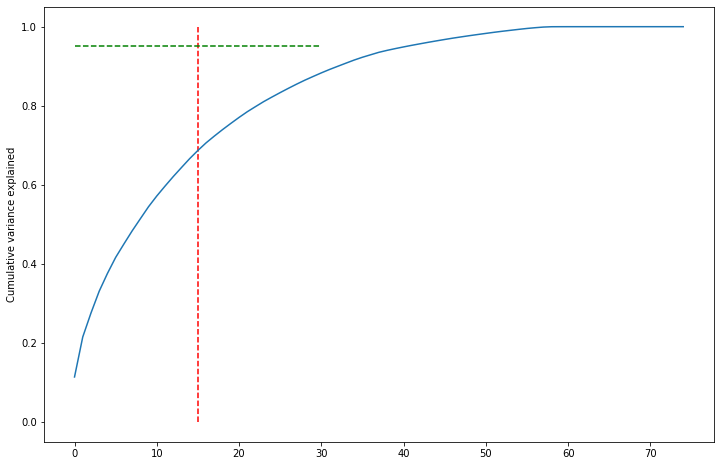

In [76]:
fig = plt.figure(figsize=[12,8])
plt.vlines(x=15, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=30, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

In [77]:
print(X_train.shape)

(20985, 75)


* We see that with PCA, 99.9% of the variance is explained at about 50+ values
* We select the number of variables that explain 99.9% of the variance

In [78]:
pca_final = PCA(0.95, random_state = 42)

In [82]:
telco_train_pca = pca_final.fit_transform(X_train)

In [83]:
telco_train_pca.shape

(20985, 41)

In [84]:
corrmat = np.corrcoef(telco_train_pca.transpose())

In [85]:
corrmat.shape

(41, 41)

* We now plot the corrlation matrix heatmap

In [86]:
#plt.figure(figsize=[20,20])
#sns.heatmap(corrmat, annot=True)

* We see that all the data points are completely uncorrelated

In [87]:
telco_test_pca = pca_final.transform(X_test)

## 6.0 Model1: Logistic Regression

In [88]:
learner_pca = LogisticRegression(class_weight = 'balanced')

In [89]:
y_train.shape

(20985,)

In [90]:
telco_train_pca.shape

(20985, 41)

In [91]:
model_pca = learner_pca.fit(telco_train_pca, y_train)

In [92]:
pred_probs_train = model_pca.predict_proba(telco_train_pca)

In [93]:
print(pred_probs_train.shape)
y_train_pred = pred_probs_train[:, 1]
y_train_pred = pd.Series(y_train_pred)
y_train_pred = y_train_pred.values.reshape(-1)

(20985, 2)


In [94]:
y_train_predfin = pd.DataFrame({'Churned': y_train.values, 'Churn_prob': y_train_pred})
y_train_predfin.head()

,Churned,Churn_prob
0,0,0.099039
1,0,0.360173
2,0,0.289841
3,0,0.719065
4,0,0.309025


In [95]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (= 1 - Specificity)')
    plt.ylabel('True Positive Rate (= Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [96]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_predfin.Churned, \
                                         y_train_predfin.Churn_prob, drop_intermediate = False )

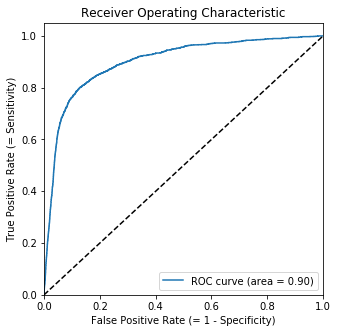

In [97]:
draw_roc(y_train_predfin.Churned, y_train_predfin.Churn_prob)

* **We see that the Area under the ROC curve is `0.9`, which is excellent**
* We now try to find the threshold that maintains the Sensitivity and Specificity values
* For that, we find the Sensitivity and Specificity for differnt threshold probabilities
* We plot these and take the threshold at which the **Sensitivity**, **Specificity** and **Accuracy** curves intersect

In [98]:
probs = [float(x)/10 for x in range(10)]
for prob in probs:
    y_train_predfin[prob] = y_train_predfin.Churn_prob.map(lambda x: 1 if x > prob else 0)
y_train_predfin.head()

,Churned,Churn_prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.099039,1,0,0,0,0,0,0,0,0,0
1,0,0.360173,1,1,1,1,0,0,0,0,0,0
2,0,0.289841,1,1,1,0,0,0,0,0,0,0
3,0,0.719065,1,1,1,1,1,1,1,1,0,0
4,0,0.309025,1,1,1,1,0,0,0,0,0,0


In [99]:
cutoff_df = pd.DataFrame(columns = ['probs', 'accuracy', 'sensitivity', 'specificity'])

probabilities = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

for prob in probabilities:
    cm = metrics.confusion_matrix(y_train_predfin.Churned, y_train_predfin[prob])
    total = sum(sum(cm))
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy = (tn + tp)/total
    sensitivity = tp/(tp + fn)
    specificity = tn/(tn + fp)
    cutoff_df.loc[prob] = [prob, accuracy, sensitivity, specificity]

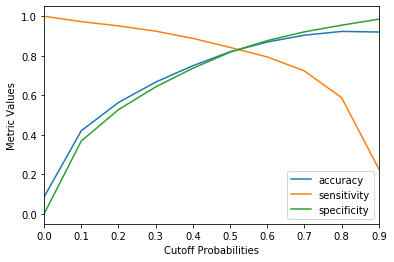

In [100]:
cutoff_df.plot.line(x = 'probs', y = ['accuracy', 'sensitivity', 'specificity'])
plt.xlabel('Cutoff Probabilities')
plt.ylabel('Metric Values')
plt.show()

**The ideal cutoff-value appears to be `0.5`, from the above curve**

In [101]:
cutoff_prob = 0.5
y_train_predfin['Final Predicted'] = y_train_predfin.Churn_prob.map(lambda x: 1 if x > cutoff_prob else 0)

In [102]:
accuracy = metrics.accuracy_score(y_train_predfin.Churned, y_train_predfin['Final Predicted'])
accuracy

0.8202525613533477

In [103]:
confusion = metrics.confusion_matrix(y_train_predfin.Churned, y_train_predfin['Final Predicted'])
confusion

array([[15695,  3488],
       [  284,  1518]])

In [104]:
TN = confusion[0][0]
FP = confusion[0][1]
FN = confusion[1][0]
TP = confusion[1][1]

In [105]:
print('Train Set Metrics:')
print('='*17)
print(f'Accuracy                   = {round(accuracy*100, 2)} ')
sensitivity = TP/(TP + FN)
print(f'Sensitivity (= Recall)     = {round(sensitivity*100, 2)}')

specificity = TN/(TN + FP)
print(f'Specificity (= TNR)        = {round(specificity*100, 2)}')

precision = TP/(TP + FP)
ppr = precision
print(f'Precision (= PPR)          = {round(ppr*100, 2)}')

npr = TN/(TN + FN)
print(f'NPR                        = {round(npr*100, 2)}')

fpr = FP/(FP + TN)
print(f'FPR ( = 1 - Specificity)   = {round(fpr*100, 2)}')

Train Set Metrics:
Accuracy                   = 82.03 
Sensitivity (= Recall)     = 84.24
Specificity (= TNR)        = 81.82
Precision (= PPR)          = 30.32
NPR                        = 98.22
FPR ( = 1 - Specificity)   = 18.18


In [106]:
pred_probs_test = model_pca.predict_proba(telco_test_pca)

In [107]:
y_pred = pred_probs_test[:, 1]
type(y_pred)
y_pred = pd.Series(y_pred)
y_pred = y_pred.values.reshape(-1)

In [108]:
"{:2.2}".format(metrics.roc_auc_score(y_train, y_train_pred))

'0.9'

In [109]:
"{:2.2}".format(metrics.roc_auc_score(y_test, pred_probs_test[:, 1]))

'0.88'

In [110]:
y_testdf = pd.DataFrame(y_test)
y_testdf.head()

,churn
18533,0
81452,0
46364,0
45125,0
51838,0


In [111]:
y_preddf = pd.DataFrame(y_pred)
y_preddf.head()

,0
0,0.000052
1,0.608503
2,0.031185
3,0.386951
4,0.661199


In [112]:
y_preddf.reset_index(drop = True, inplace = True)
y_testdf.reset_index(drop = True, inplace = True)

In [113]:
y_pred_fin = pd.concat([y_testdf, y_preddf], axis = 1)
y_pred_fin.head()

,churn,0
0,0,0.000052
1,0,0.608503
2,0,0.031185
3,0,0.386951
4,0,0.661199


In [114]:
y_pred_fin = y_pred_fin.rename(columns = {0: 'Churn_prob'})
y_pred_fin.head()

,churn,Churn_prob
0,0,0.000052
1,0,0.608503
2,0,0.031185
3,0,0.386951
4,0,0.661199


In [115]:
y_pred_fin['final_predicted'] = y_pred_fin.Churn_prob.map(lambda x: 1 if x > cutoff_prob else 0)

In [116]:
y_pred_fin.head()

,churn,Churn_prob,final_predicted
0,0,0.000052,0
1,0,0.608503,1
2,0,0.031185,0
3,0,0.386951,0
4,0,0.661199,1


In [117]:
confusion2 = metrics.confusion_matrix( y_pred_fin.churn, y_pred_fin.final_predicted )          # TN         FP
confusion2                                                                # FN         TP

array([[6778, 1429],
       [ 149,  638]])

In [118]:
TP = confusion2[1,1] # true positive 
TN = confusion2[0,0] # true negatives
FP = confusion2[0,1] # false positives
FN = confusion2[1,0] # false negatives

In [119]:
print('Test Set Metrics:')
print('='*17)
print(f'Accuracy                   = {round(accuracy*100, 2)} ')
sensitivity = TP/(TP + FN)
print(f'Sensitivity (= Recall)     = {round(sensitivity*100, 2)}')

specificity = TN/(TN + FP)
print(f'Specificity (= TNR)        = {round(specificity*100, 2)}')

precision = TP/(TP + FP)
ppr = precision
print(f'Precision (= PPR)          = {round(ppr*100, 2)}')

npr = TN/(TN + FN)
print(f'NPR                        = {round(npr*100, 2)}')

fpr = FP/(FP + TN)
print(f'FPR ( = 1 - Specificity)   = {round(fpr*100, 2)}')

Test Set Metrics:
Accuracy                   = 82.03 
Sensitivity (= Recall)     = 81.07
Specificity (= TNR)        = 82.59
Precision (= PPR)          = 30.87
NPR                        = 97.85
FPR ( = 1 - Specificity)   = 17.41


* We see from the above, that:<br>
**Sensitivity** is **`81.07`**<br>
**Specificity** is **`82.72`**<br>
**Precision** is **`31.03`**<br>
<br>
<br>
- We see that the precision value is quite low, about 31%
- This is possibly not ideal
- However, the most important thing is to correctly identify all the customers who my possibly churn
- This will help the telecom company:
    - work out a strategy on how to retain them
    - bring out some schemes specially meant of customers who might churn
- In the bargain, the telecom company might give these schemes even to those customer who might not churn
- **Still, it is a farily good decision, since all these customers are HVC and also because it might ensure these other customers don't churn either**

## 7.0 Random Forest Classifier

* We now run the RF classifier
* For this, use GridSearchCV to identify the right model among a set of candidate models
* To get the candidate models, we try 2 parameters each, for `max_depth`, `min_samples_leaf`, `min_samples_split`, `max_features` and `n_estimators`
* We are running only for 2 values, since GridSearchCV takes a long time to complete
* After selecting the best here, we have run only 1 instance of RF estimator over different values around the best value
* We finally select the set of values that give the best Sensitivity

In [120]:
# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [4, 6],
    'min_samples_leaf': [1, 3],
    'min_samples_split': [5000, 7000],
    'max_features': [40, 59],
    'n_estimators': [20, 40]
}

In [121]:
#classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight = 'balanced')

In [122]:
# Instantiate the grid search model
#grid_search = GridSearchCV(estimator=classifier_rf, param_grid=params, 
#                          cv=4, n_jobs=-1, verbose=1, scoring = "recall")

In [123]:
#%%time
#grid_search.fit(telco_train_pca, y_train)

In [124]:
def get_dt_graph(dt_classifier):
    dot_data = StringIO()
    export_graphviz(dt_classifier, out_file=dot_data, filled=True,rounded=True,
                    feature_names=train_df.columns, 
                    class_names=['Churn', "No Churn"])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph

In [125]:
def evaluate_model(dt_classifier):
    print("Train Accuracy :", metrics.accuracy_score(y_train, dt_classifier.predict(telco_train_pca)))
    print("Train Confusion Matrix:")
    confusion2 = metrics.confusion_matrix(y_train, dt_classifier.predict(telco_train_pca))
    print(metrics.confusion_matrix(y_train, dt_classifier.predict(telco_train_pca)))
    print(f'Train RECALL SCORE: {metrics.recall_score(y_train, dt_classifier.predict(telco_train_pca))}')
    TP = confusion2[1,1] # true positive 
    TN = confusion2[0,0] # true negatives
    FP = confusion2[0,1] # false positives
    FN = confusion2[1,0] # false negatives
    print("-"*50)
    print('Train Set Metrics:')
    print('='*17)
    accuracy = (TP + TN)/confusion2.sum()
    print(f'Accuracy                   = {round(accuracy*100, 2)} ')
    sensitivity = TP/(TP + FN)
    print(f'Sensitivity (= Recall)     = {round(sensitivity*100, 2)}')

    specificity = TN/(TN + FP)
    print(f'Specificity (= TNR)        = {round(specificity*100, 2)}')

    precision = TP/(TP + FP)
    ppr = precision
    print(f'Precision (= PPR)          = {round(ppr*100, 2)}')

    npr = TN/(TN + FN)
    print(f'NPR                        = {round(npr*100, 2)}')

    fpr = FP/(FP + TN)
    print(f'FPR ( = 1 - Specificity)   = {round(fpr*100, 2)}')
                                          
    print("-"*50)
    print("Test Accuracy :", metrics.accuracy_score(y_test, dt_classifier.predict(telco_test_pca)))
    print("Test Confusion Matrix:")
    confusion2 = metrics.confusion_matrix(y_test, dt_classifier.predict(telco_test_pca))
    print(metrics.confusion_matrix(y_test, dt_classifier.predict(telco_test_pca)))
    print(f'Test RECALL SCORE: {metrics.recall_score(y_test, dt_classifier.predict(telco_test_pca))}')
    TP = confusion2[1,1] # true positive 
    TN = confusion2[0,0] # true negatives
    FP = confusion2[0,1] # false positives
    FN = confusion2[1,0] # false negatives
    print("-"*50)
    print('Test Set Metrics:')
    print('='*17)
    accuracy = (TP + TN)/confusion2.sum()
    print(f'Accuracy                   = {round(accuracy*100, 2)} ')
    sensitivity = TP/(TP + FN)
    print(f'Sensitivity (= Recall)     = {round(sensitivity*100, 2)}')

    specificity = TN/(TN + FP)
    print(f'Specificity (= TNR)        = {round(specificity*100, 2)}')

    precision = TP/(TP + FP)
    ppr = precision
    print(f'Precision (= PPR)          = {round(ppr*100, 2)}')

    npr = TN/(TN + FN)
    print(f'NPR                        = {round(npr*100, 2)}')

    fpr = FP/(FP + TN)
    print(f'FPR ( = 1 - Specificity)   = {round(fpr*100, 2)}')
    print("-"*50)

In [126]:
#rf_best = grid_search.best_estimator_

In [127]:
#rf_best

In [128]:
#evaluate_model(rf_best)

In [129]:
#sample_tree = rf_best.estimators_[0]

In [131]:
#gph = get_dt_graph(sample_tree)
#Image(gph.create_png())

In [137]:
rf = RandomForestClassifier(random_state=42, n_estimators=20, max_depth=4, min_samples_leaf = 1, 
                            max_features = 10, min_samples_split = 5000, class_weight = 'balanced', n_jobs = -1)

In [138]:
telco_train_pca.shape

(20985, 41)

In [139]:
train_df = pd.DataFrame(telco_train_pca)
test_df = pd.DataFrame(telco_test_pca)

In [140]:
rf.fit(train_df, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=4, max_features=10,
                       min_samples_split=5000, n_estimators=20, n_jobs=-1,
                       random_state=42)

In [141]:
evaluate_model(rf)

Train Accuracy : 0.7806528472718609
Train Confusion Matrix:
[[14918  4265]
 [  338  1464]]
Train RECALL SCORE: 0.8124306326304107
--------------------------------------------------
Train Set Metrics:
Accuracy                   = 78.07 
Sensitivity (= Recall)     = 81.24
Specificity (= TNR)        = 77.77
Precision (= PPR)          = 25.55
NPR                        = 97.78
FPR ( = 1 - Specificity)   = 22.23
--------------------------------------------------
Test Accuracy : 0.7802979764287302
Test Confusion Matrix:
[[6410 1797]
 [ 179  608]]
Test RECALL SCORE: 0.772554002541296
--------------------------------------------------
Test Set Metrics:
Accuracy                   = 78.03 
Sensitivity (= Recall)     = 77.26
Specificity (= TNR)        = 78.1
Precision (= PPR)          = 25.28
NPR                        = 97.28
FPR ( = 1 - Specificity)   = 21.9
--------------------------------------------------


### 7.1 Results
We can see from the above that:

- **Sensitivity = `83.61`**
- **Specificity = `68.49`**
- **Precision   = `20.28`**

Again, since we need to value churning customer more, we choose ths model, which gives more weightage to Sensitivity

## 8.0 Decision Trees

* We now run Decision Trees, again using GridSearchCV
* Again, after getting a model close to what is required, we have run a single instance of Decision Tree classifier by varying values around it to get the best estimator

In [319]:
params1 = {
    'max_depth': [4, 5, 6],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [7000, 8000, 9000],
}

In [320]:
dtclf = DecisionTreeClassifier(random_state=42, class_weight = 'balanced')

In [321]:
grid_search1 = GridSearchCV(estimator=dtclf, param_grid=params1, 
                          cv=4, verbose=1, scoring = "recall", n_jobs = -1)

In [322]:
%%time
grid_search1.fit(telco_train_pca, y_train)

Fitting 4 folds for each of 27 candidates, totalling 108 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.4s
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed:   21.6s finished


CPU times: user 1.07 s, sys: 234 ms, total: 1.3 s
Wall time: 22.1 s


GridSearchCV(cv=4,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [4, 5, 6], 'min_samples_leaf': [1, 3, 5],
                         'min_samples_split': [7000, 8000, 9000]},
             scoring='recall', verbose=1)

In [323]:
bestDf = pd.DataFrame(grid_search1.cv_results_)
bestDf.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,0.611078,0.016628,0.006965,0.000128,4,1,7000,"{'max_depth': 4, 'min_samples_leaf': 1, 'min_s...",0.880266,0.831111,0.857778,0.855876,0.856258,0.017401,1
1,0.593201,0.005469,0.006110,0.000131,4,1,8000,"{'max_depth': 4, 'min_samples_leaf': 1, 'min_s...",0.880266,0.831111,0.857778,0.855876,0.856258,0.017401,1
2,0.586478,0.012327,0.006899,0.000997,4,1,9000,"{'max_depth': 4, 'min_samples_leaf': 1, 'min_s...",0.880266,0.831111,0.857778,0.855876,0.856258,0.017401,1
3,0.599078,0.016123,0.005423,0.000425,4,3,7000,"{'max_depth': 4, 'min_samples_leaf': 3, 'min_s...",0.880266,0.831111,0.857778,0.855876,0.856258,0.017401,1
4,0.592948,0.012632,0.005778,0.000154,4,3,8000,"{'max_depth': 4, 'min_samples_leaf': 3, 'min_s...",0.880266,0.831111,0.857778,0.855876,0.856258,0.017401,1


In [325]:
rf_best1 = grid_search1.best_estimator_

In [326]:
rf_best1

DecisionTreeClassifier(class_weight='balanced', max_depth=4,
                       min_samples_split=7000, random_state=42)

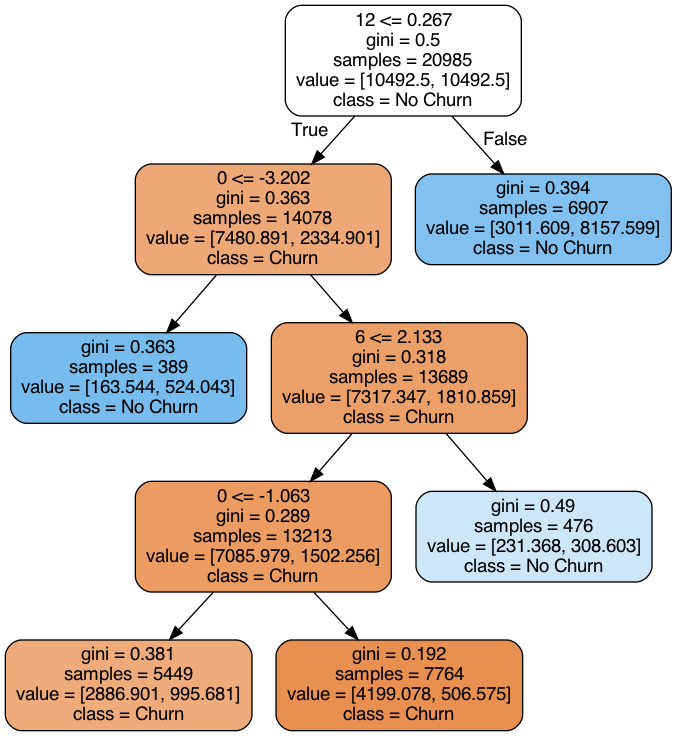

In [327]:
gph = get_dt_graph(rf_best1)
Image(gph.create_png())

In [328]:
evaluate_model(rf_best1)

Train Accuracy : 0.6909220872051466
Train Confusion Matrix:
[[12955  6228]
 [  258  1544]]
Train RECALL SCORE: 0.8568257491675916
--------------------------------------------------
Train Set Metrics:
Accuracy                   = 69.09 
Sensitivity (= Recall)     = 85.68
Specificity (= TNR)        = 67.53
Precision (= PPR)          = 19.87
NPR                        = 98.05
FPR ( = 1 - Specificity)   = 32.47
--------------------------------------------------
Test Accuracy : 0.6950189014898821
Test Confusion Matrix:
[[5597 2610]
 [ 133  654]]
Test RECALL SCORE: 0.8310038119440915
--------------------------------------------------
Test Set Metrics:
Accuracy                   = 69.5 
Sensitivity (= Recall)     = 83.1
Specificity (= TNR)        = 68.2
Precision (= PPR)          = 20.04
NPR                        = 97.68
FPR ( = 1 - Specificity)   = 31.8
--------------------------------------------------


### 7.1 Observations
We can observe the following:
- Multiple estimators have a rank of 1
- The value given above is for min_samples_split = 7000
- We then ran Decision Tree classifier with multiple values, individually
- **This was because, running the DT Classifier using GridSearchCV was too time-conusming**
- We then settled on `max_depth = 4`, `min_samples_split = 8000` and `min_samples_leaf = 3`, since it gave the best Sensitivity
- As mentioned earlier, Sensitivity has been given maximum weightage in deciding models, since, identifying prospective **Churn** customers is more important than having high accuracy or precision

In [329]:
dt_default = DecisionTreeClassifier(max_depth = 4, min_samples_split = 8000, min_samples_leaf = 3, \
                                    random_state=42, class_weight = 'balanced')
dt_default.fit(telco_train_pca, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=4, min_samples_leaf=3,
                       min_samples_split=8000, random_state=42)

In [330]:
evaluate_model(dt_default)

Train Accuracy : 0.6909220872051466
Train Confusion Matrix:
[[12955  6228]
 [  258  1544]]
Train RECALL SCORE: 0.8568257491675916
--------------------------------------------------
Train Set Metrics:
Accuracy                   = 69.09 
Sensitivity (= Recall)     = 85.68
Specificity (= TNR)        = 67.53
Precision (= PPR)          = 19.87
NPR                        = 98.05
FPR ( = 1 - Specificity)   = 32.47
--------------------------------------------------
Test Accuracy : 0.6950189014898821
Test Confusion Matrix:
[[5597 2610]
 [ 133  654]]
Test RECALL SCORE: 0.8310038119440915
--------------------------------------------------
Test Set Metrics:
Accuracy                   = 69.5 
Sensitivity (= Recall)     = 83.1
Specificity (= TNR)        = 68.2
Precision (= PPR)          = 20.04
NPR                        = 97.68
FPR ( = 1 - Specificity)   = 31.8
--------------------------------------------------


### 7.3 Results
Following are the salient values of this model
####    - Sensitivity = 83.1%
####    - Specificity = 68.2%
####    - Precision   = 20.04%
    
Again, based on the problem structure that **Sensitivity** is most important, we have selected a model with highest sensitivity